In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import datetime as dt
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect

# Reflect Tables into SQLAlchemy ORM

In [3]:
# SQL Connection
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
Base = automap_base()
Base.prepare(engine, reflect=True)

In [4]:
# Use the Inspector to explore the database and print the table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [5]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [6]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [7]:
data = engine.execute("select * from measurement limit 5").fetchall()
for x in data:
    print(x)

(1, 'USC00519397', '2010-01-01', 0.08, 65.0)
(2, 'USC00519397', '2010-01-02', 0.0, 63.0)
(3, 'USC00519397', '2010-01-03', 0.0, 74.0)
(4, 'USC00519397', '2010-01-04', 0.0, 76.0)
(5, 'USC00519397', '2010-01-06', None, 73.0)


In [8]:
# Reflect Database into ORM class
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Precipitation Analysis

In [12]:
# Last Date
last_date = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).first().date
last_date

'2017-08-23'

In [13]:
past12mth_date = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=365)
past12mth_date

datetime.datetime(2016, 8, 23, 0, 0)

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
prec_results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= past12mth_date).\
    group_by(Measurement.date).all()         
#print(prec_results)


In [15]:
#Pandas DataFrame for data and precipitation scores for the last 12 months
prec_df = pd.DataFrame(prec_results, columns=['Date', 'Precipitation'])
prec_df = prec_df.set_index('Date')
prec_df.head()

,Precipitation
Date,
2016-08-24,1.45
2016-08-25,0.11
2016-08-26,0.01
2016-08-27,NaN
2016-08-28,2.07


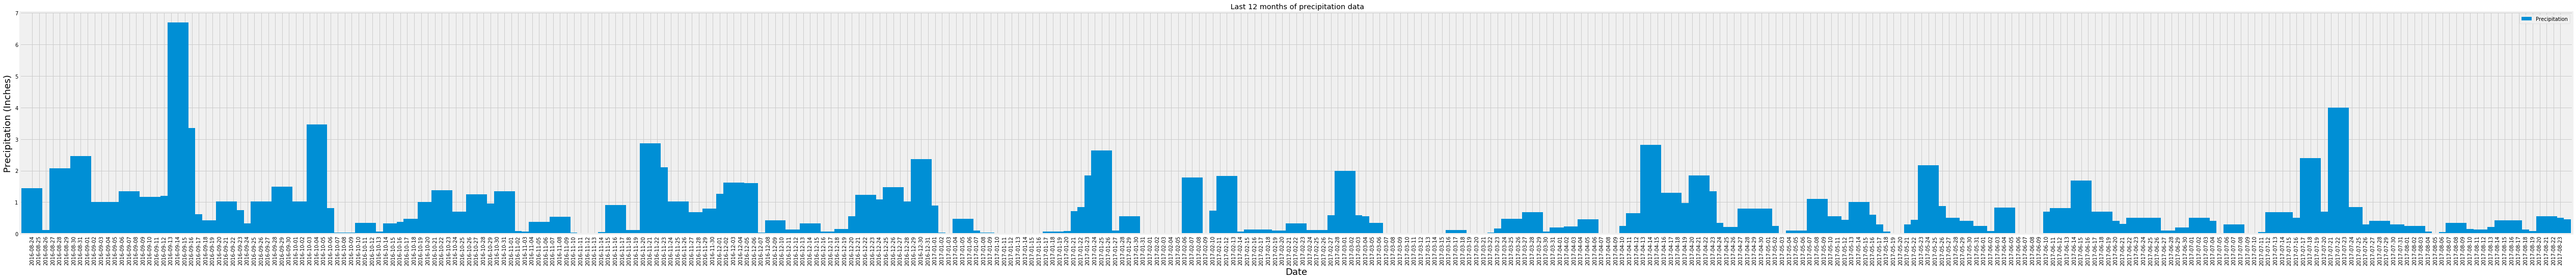

<Figure size 432x288 with 0 Axes>

In [21]:
#Plot the results using the DataFrame `plot` method
prec_df.plot(kind="bar", width=3, figsize=(80,8),rot=90)
plt.title(" Last 12 months of precipitation data")
plt.ylabel("Precipitation (Inches)", size=18)
plt.xlabel("Date", size=18)
plt.grid(True)
plt.show()
plt.tight_layout()
plt.savefig("Images/Precipitation.png")


In [51]:
# Use Pandas to calculate the summary statistics for the precipitation data

prec_df.describe()

,Precipitation
count,344.000000
mean,0.431308
std,0.705240
min,0.000000
25%,0.010000
50%,0.140000
75%,0.565000
max,6.700000


### Station Analysis

In [60]:
data = engine.execute("select * from Station").fetchall()
data

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [57]:
# Design a query to show how many stations are available in this dataset?
station_ct = session.query(Station.station).count()
print(station_ct) 

9


In [64]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_station = session.query(Measurement.station, func.count(Measurement.station)).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()
active_station    



[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [68]:
most_active_st = active_station[0][0]
most_active_st

'USC00519281'

In [71]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temp_station = session.query(Measurement.station,
                               func.min(Measurement.tobs),
                               func.max(Measurement.tobs),  
                               func.avg(Measurement.tobs)).\
            filter(Measurement.station == most_active_st).all()
temp_station

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [100]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
highT_station = session.query(Measurement.station, Measurement.tobs).\
                filter(Measurement.station == most_active_st).\
                filter(Measurement.date >= past12mth_date).all()
   
highT_station_df = pd.DataFrame(highT_station, columns=['Station', 'Tobs'])
highT_station_df = highT_station_df.set_index('Station')
highT_station_df.head()

,Tobs
Station,
USC00519281,77.0
USC00519281,80.0
USC00519281,80.0
USC00519281,75.0
USC00519281,73.0


<function matplotlib.pyplot.show(*args, **kw)>

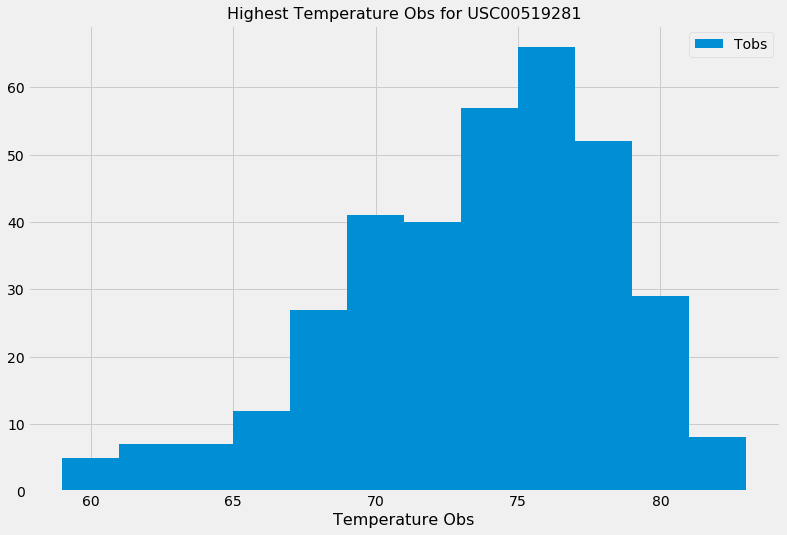

In [106]:
highT_station_df.hist(bins=12, figsize=(12,8),label = 'Tobs')
plt.grid(True)
plt.title("Highest Temperature Obs for " + most_active_st,fontsize=16)
plt.xlabel("Temperature Obs", fontsize=16)
plt.savefig("Images/HighestStationTemps.png")
plt.legend(loc='upper right')
plt.show

In [23]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    temp_results = session.query(func.min(Measurement.tobs),
                              func.avg(Measurement.tobs),
                              func.max(Measurement.tobs).\
               filter(Measurement.date >= start_date).\
               filter(Measurement.date <= end_date).all() 
    return temp_results
                                 
calc_temps('2017-01-01', '2017-12-31')

SyntaxError: invalid syntax (<ipython-input-23-929164e8a54a>, line 9)

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
